In [251]:
from typing import Dict

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [253]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset

In [254]:
from pathlib import Path

In [255]:
from tqdm import tqdm_notebook as tqdm

In [256]:
from torchvision import transforms, datasets

In [257]:
import wget
import os
import requests

In [258]:
import json
import requests

In [259]:
from os import listdir
from os.path import isfile, join

In [85]:
def get_links(user: str, repo: str, path: str):
    url = f'https://api.github.com/repos/{user}/{repo}/contents/{path}'
    files = requests.get(url=url).json()
    return list(map(lambda file: file['download_url'], files))

In [87]:
def download_data():
    urls = get_links(user="Zhenye-Na", repo="pokemon-gan", path="data/preprocessed_data")
    path = os.getcwd()
    path = path + '/data'
    try:
        os.mkdir(path)
    except OSError:
        print (f'Exists {path}')
    else:
        print (f'Created {path}')
    for url in urls:
        filename = url.rpartition('/')[2]
        try:
            print(f'\r Downloading: {filename}', end='')
            wget.download(url, out=path + '/' + filename)
        except requests.exceptions.HTTPError as e:
            print(e)

In [88]:
# download_data()

Created /Users/jetbrains/jupyter/data
 Downloading: 99.jpga.jpg.jpgpgpgg

In [260]:
def read_images_content(filepath: Path):
    files = [f for f in listdir(filepath) if isfile(join(filepath, f))]
    dirname = os.path.basename(filepath)
    images = [plt.imread(dirname + '/' + f) for f in files]
    return images

In [261]:
class PokemonDataset(Dataset):
    def __init__(self, data_file: Path, normalizer: float = 255.):
        self.data = read_images_content(data_file) #/ normalizer

    def __getitem__(self, index: int) -> torch.Tensor:
        data = self.data[index]
        return data.mean(axis=2)

    def __len__(self):
        return len(self.data)

In [262]:
data = PokemonDataset(Path('data/'))

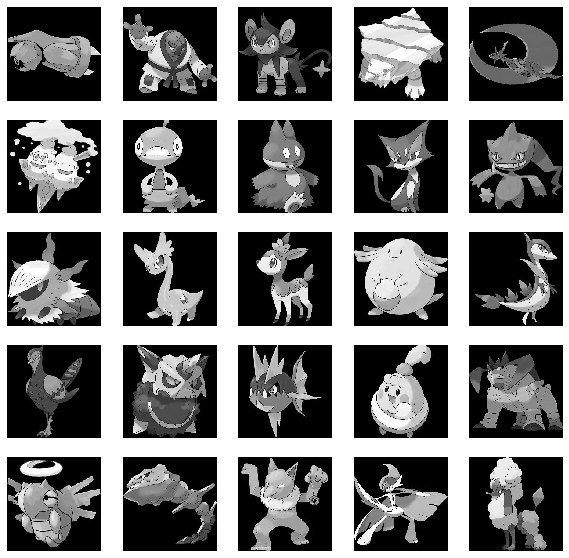

In [263]:
ind = np.random.randint(1, high=len(data), size=25)
pokemons = [data[i] for i in ind]
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(pokemons[i*5 + j].reshape(256, 256), cmap='gray')
        ax[i,j].axis('off')

In [264]:
batch_size = 10
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

In [265]:
IMG_SIZE = 65536
LAYER_SIZE_1 = 512
LAYER_SIZE_2 = 256
LATENT_DIM = 128
EXPAND_DIM = 1024
FEAT_SIZE = 65536
WIDTH = 256
HEIGHT = 256

In [266]:
def hidden(in_features, out_features, negative_slope=0.2, dropout_rate=0.3, dropout=True):
    h = nn.Sequential(
    nn.Linear(in_features, out_features),
    nn.LeakyReLU(negative_slope=negative_slope))
    if dropout:
        h.add_module('dropout', nn.Dropout(dropout_rate))
    return h

In [267]:
def output_layer(in_features, out_features, activation_func):
    return nn.Sequential(
    nn.Linear(in_features=in_features, out_features=out_features),
    activation_func)

In [268]:
class Discriminator(nn.Module):
    def __init__(self, n_features=IMG_SIZE):
        super().__init__()
        self.hidden_layers = nn.Sequential(
            hidden(n_features, EXPAND_DIM),
            hidden(EXPAND_DIM, LAYER_SIZE_1),
            hidden(LAYER_SIZE_1, LAYER_SIZE_2))
        self.output_layer = output_layer(LAYER_SIZE_2, 1, nn.Sigmoid())

    @property
    def device(self) -> torch.device:
        return self.output_layer[0].weight.device
    
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [269]:
class Generator(nn.Module):
    def __init__(self, n_features=LATENT_DIM, n_output=IMG_SIZE):
        super().__init__()
        self.normal = Normal(loc=0., scale=1.)
        self.hidden_layers = nn.Sequential(
            hidden(n_features, LAYER_SIZE_2, dropout=False),
            hidden(LAYER_SIZE_2, LAYER_SIZE_1, dropout=False),
            hidden(LAYER_SIZE_1, EXPAND_DIM, dropout=False))
        self.output_layer = output_layer(EXPAND_DIM, n_output, nn.ReLU())

    @property
    def device(self) -> torch.device:
        return self.output_layer[0].weight.device
    
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    
    def noise(self, sample_size: int) -> torch.Tensor:
        z = self.normal.sample(sample_shape=(sample_size, LATENT_DIM)).to(self.device)
        return z
    
    def sample(self, sample_size: int) -> torch.Tensor:
        z = self.noise(sample_size)
        return self(z)

In [270]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [271]:
learning_rate = 0.0002

In [272]:
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optim = optim.Adam(generator.parameters(), lr=learning_rate)

In [273]:
loss_function = nn.BCELoss()

In [274]:
def ones_tensor(size, device):
    t = torch.ones(size).unsqueeze(-1).to(device)
    return t


def zeros_tensor(size, device):
    t = torch.zeros(size).unsqueeze(-1).to(device)
    return t

In [275]:
def discriminator_step(discriminator, loss_function, true_data, fake_data, optimizer=None):
    shape = true_data.size(0)
    device = true_data.device
    true_output = discriminator(true_data)
    true_loss = loss_function(true_output, ones_tensor(shape, device))
    fake_output = discriminator(fake_data)
    fake_loss = loss_function(fake_output, zeros_tensor(shape, device))
    loss = true_loss + fake_loss
    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

In [276]:
def generator_step(discriminator, loss_function, fake_data, optimizer=None):
    shape = fake_data.size(0)
    device = fake_data.device
    output = discriminator(fake_data)
    loss = loss_function(output, ones_tensor(shape, device))
    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

In [277]:
def images_to_vectors(images, n_features=IMG_SIZE):
    return images.view(images.size(0), n_features)

In [278]:
def plot_sample_images(generator, cols=5, rows=5, width=256, height=256, figsize=(10, 10)):
    sample = generator.sample(cols * rows).data.cpu().numpy()
    fig, ax = plt.subplots(cols, rows, sharex='col', sharey='row', figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(sample[i*rows + j].reshape(width, height), cmap='gray')
            ax[i,j].axis('off')

In [279]:
def train_gan(loss_function, num_epochs=100):
    device = discriminator.device
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        print(f'\r epoch: [{epoch+1}/{num_epochs}]', end='')
        d_loss, g_loss, b = 0, 0, 0
        for batch in tqdm(dataloader, ncols=340, desc=f'Epoch {epoch + 1}'):
            true_data = images_to_vectors(batch).to(device).float()
            sample_size = true_data.size(0)
            fake_data = generator.sample(sample_size).detach()
            discriminator_loss = discriminator_step(discriminator, loss_function, true_data, fake_data, d_optim)
            fake_data = generator.sample(sample_size)
            generator_loss = generator_step(discriminator, loss_function, fake_data, g_optim)
            d_loss += discriminator_loss.data.cpu()
            g_loss += generator_loss.data.cpu()
            b += 1
        d_loss /= float(b)
        g_loss /= float(b)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        plot_sample_images(generator)
    return d_losses, g_losses

 epoch: [1/10]

 epoch: [2/10]

 epoch: [3/10]

 epoch: [4/10]

 epoch: [5/10]

KeyboardInterrupt: 

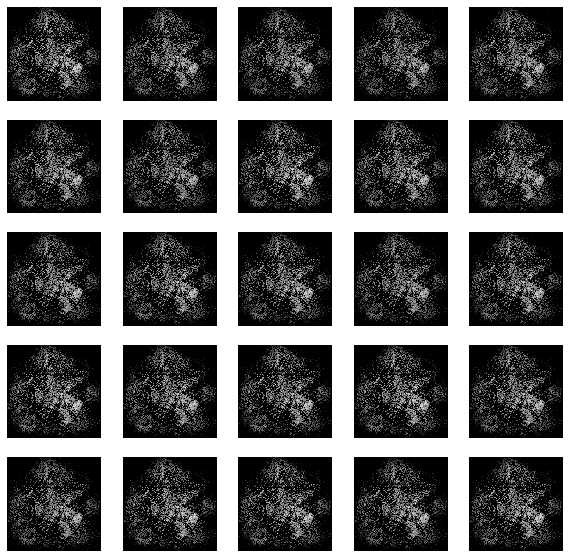

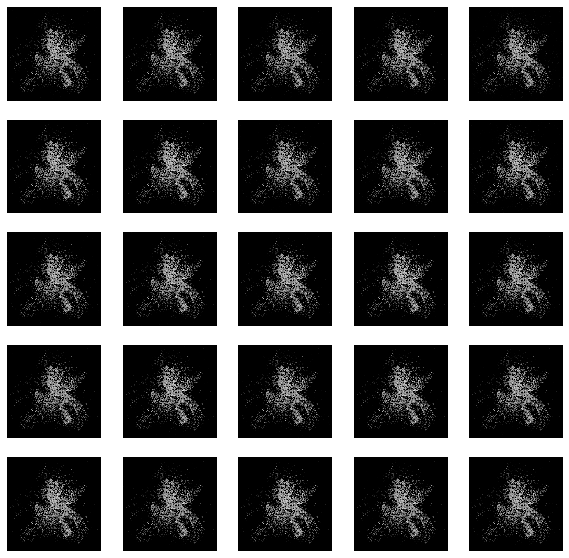

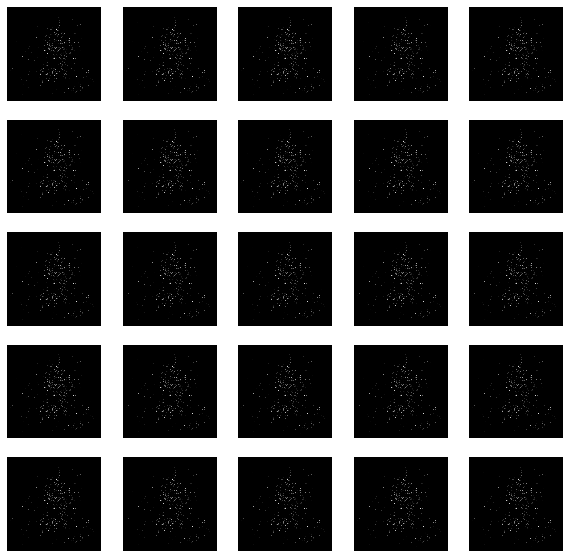

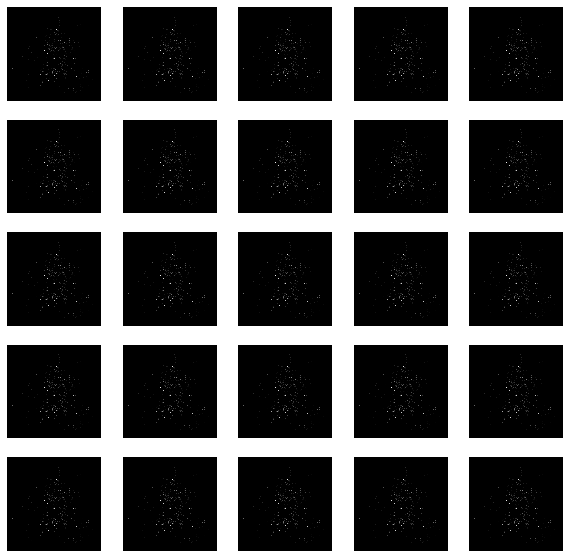

In [280]:
num_epochs = 10
d_losses, g_losses = train_gan(loss_function, num_epochs=num_epochs)

In [248]:
pokemons = generator.sample(225).data.cpu().numpy()

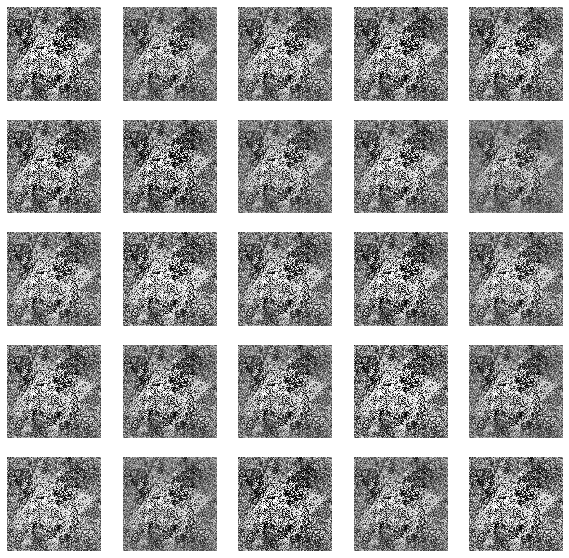

In [249]:
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(pokemons[i*5 + j].reshape(256, 256), cmap='gray')
        ax[i,j].axis('off')